In [5]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 25.5 MB/s eta 0:00:00


Head Data:
            RPM       Load       Temp
0  3247.240713  23.514805  39.314558
1  6704.285838  32.287227  52.131395
2  5391.963651  24.160839  44.952357
3  4591.950905  17.096203  43.972864
4  1936.111843  19.650870  30.377152


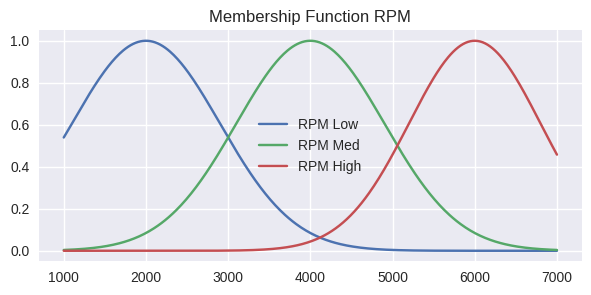

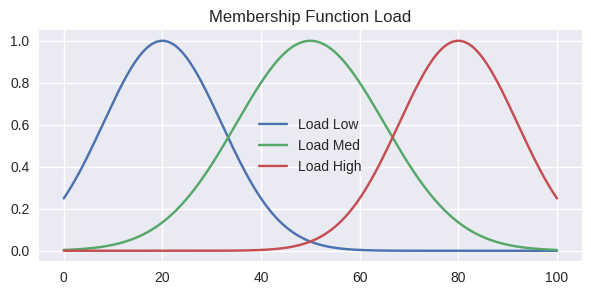

Epoch 5/30 Loss: 1.3987
Epoch 10/30 Loss: 1.3987
Epoch 15/30 Loss: 1.3987
Epoch 20/30 Loss: 1.3987
Epoch 25/30 Loss: 1.3987
Epoch 30/30 Loss: 1.3987


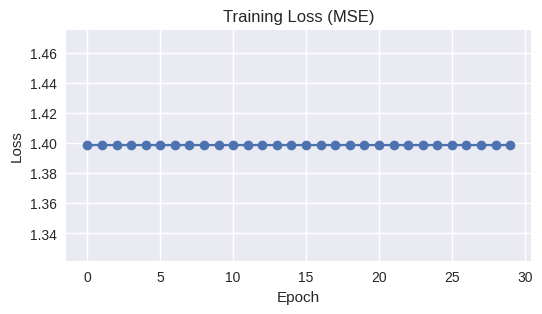

MSE: 1.5344028477813425
R2 Score: 0.9747184494330132


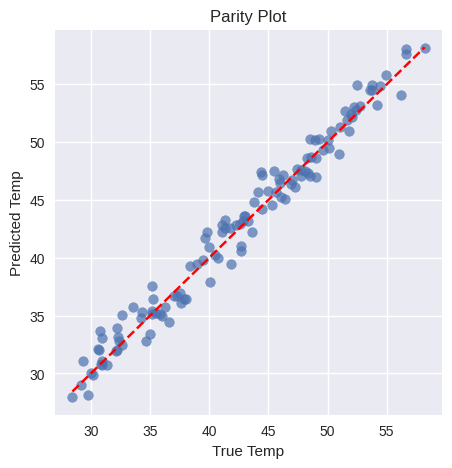

             RPM       Load       Temp  Temp_Pred
433  1606.736057  19.645351  31.476233  30.805565
150  6449.595316  19.351843  51.460469  49.788386
12   5994.655845  60.232031  50.502364  52.327957
492  2664.287098  58.618944  39.365899  38.371429
295  4133.459560  26.398744  41.448827  40.838735
228  6352.279331  69.000100  53.771060  54.914395
566  3353.464271  76.570734  44.954980  43.362549
192  6402.508343  50.471094  54.146842  53.199707
486  1272.678282  59.072911  32.304662  34.175700
186  5903.333201  56.671344  51.433652  51.521619


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")
np.random.seed(42)

# --- 1. DATA GENERATION ---
N = 600
RPM = np.random.uniform(1000, 7000, N)
Load = np.random.uniform(10, 90, N)

# Fungsi non-linear kompleks untuk Target (Temp)
Temp = (
    30
    + 0.004 * (RPM - 2000)
    + 0.09 * Load
    + 0.5 * np.sin((RPM / 7000) * 2 * np.pi)
    + 0.02 * Load * (RPM / 7000)
    + np.random.normal(0, 1.2, N)
)

data = pd.DataFrame({"RPM": RPM, "Load": Load, "Temp": Temp})
print("Head Data:\n", data.head())

# --- 2. VISUALISASI MEMBERSHIP FUNCTION ---
x_rpm = np.linspace(1000, 7000, 400)
rpm_low = fuzz.gaussmf(x_rpm, 2000, 900)
rpm_med = fuzz.gaussmf(x_rpm, 4000, 900)
rpm_high = fuzz.gaussmf(x_rpm, 6000, 800)

plt.figure(figsize=(7, 3))
plt.plot(x_rpm, rpm_low, label="RPM Low")
plt.plot(x_rpm, rpm_med, label="RPM Med")
plt.plot(x_rpm, rpm_high, label="RPM High")
plt.legend()
plt.title("Membership Function RPM")
plt.show()

x_load = np.linspace(0, 100, 400)
load_low = fuzz.gaussmf(x_load, 20, 12)
load_med = fuzz.gaussmf(x_load, 50, 15)
load_high = fuzz.gaussmf(x_load, 80, 12)

plt.figure(figsize=(7, 3))
plt.plot(x_load, load_low, label="Load Low")
plt.plot(x_load, load_med, label="Load Med")
plt.plot(x_load, load_high, label="Load High")
plt.legend()
plt.title("Membership Function Load")
plt.show()

# --- 3. CLASS ANFIS MANUAL ---
class ANFISManual:
    def __init__(self, n_inputs=2, n_mfs=3, lr=0.02):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.lr = lr

        # Inisialisasi parameter premise (Center & Sigma) secara fix/statis
        self.centers = np.array([
            np.linspace(0.1, 0.9, n_mfs) for _ in range(n_inputs)
        ])

        self.sigmas = np.array([
            np.ones(n_mfs) * 0.15 for _ in range(n_inputs)
        ])

        self.n_rules = n_mfs ** n_inputs

        # Membuat kombinasi aturan (Grid Search style)
        grids = np.meshgrid(*[np.arange(n_mfs) for _ in range(n_inputs)])
        self.rule_indices = np.vstack([g.flatten() for g in grids]).T

        # Bobot consequent (Output rules)
        self.W = np.zeros((self.n_rules, n_inputs + 1))

    def _gauss(self, x, c, s):
        # Perbaikan rumus Gaussian dari PDF
        return np.exp(-0.5 * ((x - c) / s) ** 2)

    def _firing(self, Xn):
        N = Xn.shape[0]
        F = np.zeros((N, self.n_rules))

        for r in range(self.n_rules):
            prod = np.ones(N)
            for i in range(self.n_inputs):
                idx = self.rule_indices[r, i]
                # Menghitung firing strength
                prod *= self._gauss(Xn[:, i], self.centers[i, idx], self.sigmas[i, idx])
            F[:, r] = prod
        return F

    def predict(self, Xn):
        F = self._firing(Xn)
        # Normalisasi firing strength
        Wn = F / (F.sum(1, keepdims=True) + 1e-8)

        # Extended input untuk perhitungan konsekuen (takagi-sugeno order 1)
        Xext = np.hstack([Xn, np.ones((Xn.shape[0], 1))])

        # Perhitungan output per rule
        # Harusnya dot product per rule, tapi di sini disimplifikasi matriks
        # Logika PDF: y_rules = (Wn ... wait, PDF logic is tricky here)
        # Rekonstruksi logika matriks dari fit method PDF:
        y_final = np.zeros((Xn.shape[0], 1))

        # Prediksi manual berdasarkan bobot W yang sudah dilatih
        # y = sum(wn * (ax + by + c))
        # Kita lakukan kalkulasi manual sesuai struktur data
        for r in range(self.n_rules):
            # Ambil bobot untuk rule ke-r: shape (3,)
            weights = self.W[r, :]
            # Output linier rule ke-r: shape (N,)
            rule_output = (Xext @ weights)
            # Weighted sum
            y_final[:, 0] += Wn[:, r] * rule_output

        return y_final.flatten()

    def fit(self, Xn, y, epochs=30):
        history = []
        N = Xn.shape[0]
        Xext = np.hstack([Xn, np.ones((N, 1))])

        for ep in range(epochs):
            F = self._firing(Xn)
            Wn = F / (F.sum(1, keepdims=True) + 1e-8)

            # Membangun matriks Phi untuk Least Squares
            # Phi shape: (N, n_rules * (n_inputs + 1))
            Phi = np.zeros((N, self.n_rules * (self.n_inputs + 1)))

            for r in range(self.n_rules):
                s = r * (self.n_inputs + 1)
                # Phi kolom ke-r diisi dengan Wn_r * Input
                Phi[:, s : s + self.n_inputs + 1] = Wn[:, r:r+1] * Xext

            # Mencari parameter consequent (Theta/W) menggunakan LSE
            Theta, _, _, _ = np.linalg.lstsq(Phi, y, rcond=None)

            # Reshape Theta kembali ke bentuk W (n_rules, n_inputs+1)
            self.W = Theta.reshape(self.n_rules, self.n_inputs + 1)

            # Hitung Loss
            y_pred = self.predict(Xn)
            loss = ((y.flatten() - y_pred) ** 2).mean()
            history.append(loss)

            if (ep + 1) % 5 == 0:
                print(f"Epoch {ep+1}/{epochs} Loss: {loss:.4f}")

        return history

# --- 4. PREPARASI DATA & TRAINING ---
X = data[['RPM', 'Load']].values
Y = data['Temp'].values.reshape(-1, 1)

# Normalisasi Min-Max
Xmin = X.min(0)
Xmax = X.max(0)
normalize = lambda X: (X - Xmin) / (Xmax - Xmin + 1e-8)
Xn = normalize(X)

Xtr, Xte, ytr, yte = train_test_split(Xn, Y, test_size=0.2, random_state=42)

# Inisialisasi dan Training
anfis = ANFISManual()
history = anfis.fit(Xtr, ytr, epochs=30)

# --- 5. EVALUASI ---
plt.figure(figsize=(6, 3))
plt.plot(history, marker='o')
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

y_pred = anfis.predict(Xte)
print("MSE:", mean_squared_error(yte, y_pred))
print("R2 Score:", r2_score(yte, y_pred))

plt.figure(figsize=(5, 5))
plt.scatter(yte, y_pred, alpha=0.7)
mn, mx = yte.min(), yte.max()
plt.plot([mn, mx], [mn, mx], '--', color='red')
plt.xlabel("True Temp")
plt.ylabel("Predicted Temp")
plt.title("Parity Plot")
plt.grid(True)
plt.show()

# Sample output
data['Temp_Pred'] = anfis.predict(normalize(data[['RPM', 'Load']].values))
print(data.sample(10))